# Adversarial attack on images

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 647.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.6 MB/s eta 0:

In [19]:
# Import libraries
import requests
from tqdm import trange
import numpy as np

import torch
from torch import nn
from torchvision.models import resnet50
from torchvision import transforms as T
from torch.nn import functional as F
from torch_snippets import *

from PIL import Image

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.0

zsh:1: command not found: nvidia-smi


In [2]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cpu

In [11]:
# Load the ResNet50 model with pre-trained weights, freeze all layers and set to evaluation mode
model = resnet50(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False # Freeze all layers
model = model.eval().to(device)

In [12]:
# Download a sample image of an elephant and convert it to a tensor
url = 'https://lionsvalley.co.za/wp-content/uploads/2015/11/african-elephant-square.jpg'
original_image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
original_image = np.array(original_image)
original_image = torch.Tensor(original_image)

In [13]:
# Download ImageNet classes and IDs
image_net_classes = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
image_net_classes = requests.get(image_net_classes).text
image_net_ids = eval(image_net_classes)
image_net_classes = {i:j for j,i in image_net_ids.items()}

In [16]:
# Create a function to normalize and convert an image to a tensor
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
def image2tensor(image):
    return normalize(image.clone().permute(2, 0, 1) / 255.)[None]

# Create a function to convert a tensor to an image and denormalize it
denormalize = T.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
def tensor2image(tensor):
    return (denormalize(tensor[0].clone()).permute(1, 2, 0) * 255.).type(torch.uint8)

In [17]:
# Create a function to make a prediction on an image
def predict_on_image(image):
    model.eval()
    show(image)
    tensor_image = image2tensor(image)
    pred = model(tensor_image)
    pred = F.softmax(pred, dim=-1)[0]
    prob, clss = torch.max(pred, 0)
    clss = image_net_ids[clss.item()]
    print(f'PREDICTION: `{clss}` @ {prob.item()}')

In [20]:
# Initialize a list of losses
losses = []

# Create a function to perform an attack on an image
def attack(image, model, target, epsilon=1e-6):
    """Slighly alter the image to maximize for the target class"""
    tensor_image = image2tensor(image)
    tensor_image.requires_grad = True
    pred = model(tensor_image)
    loss = nn.CrossEntropyLoss()(pred, target)
    loss.backward()
    losses.append(loss.mean().item())
    tensor_output = tensor_image - epsilon * tensor_image.grad.sign() # Gradient sign method
    output_image = tensor2image(tensor_output)
    del tensor_image
    return output_image.detach()

In [21]:
# Modify the image to target a different class
modified_images = []
desired_targets = ['lemon', 'comic book', 'sax, saxophone']

# Perform the attack on the image over 10 iterations
for target in desired_targets:
    target = torch.tensor([image_net_classes[target]])
    image_to_attack = original_image.clone()
    for _ in trange(10):
        image_to_attack = attack(image_to_attack, model, target)
    modified_images.append(image_to_attack)

100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


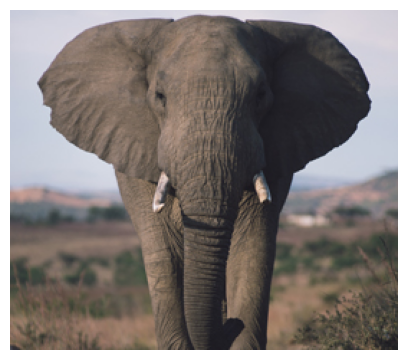

PREDICTION: `African elephant, Loxodonta africana` @ 0.5234395265579224

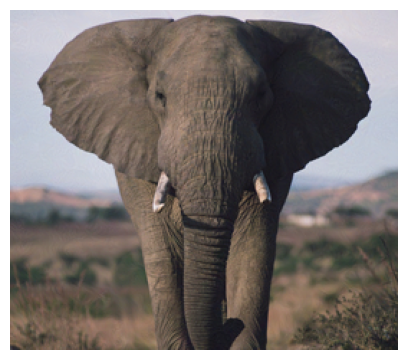

PREDICTION: `lemon` @ 0.9999904632568359

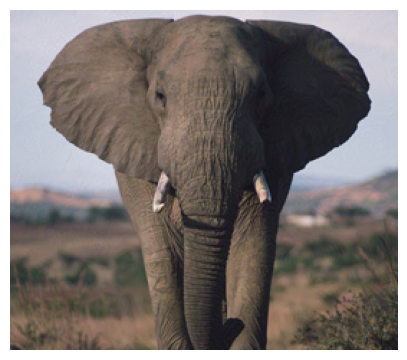

PREDICTION: `comic book` @ 0.9999850988388062

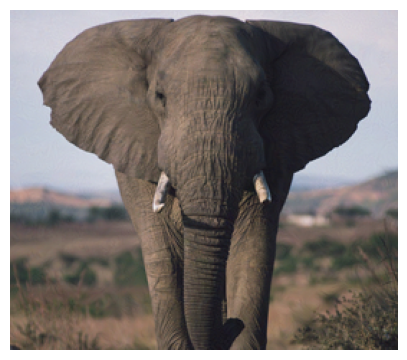

PREDICTION: `sax, saxophone` @ 0.9999991655349731

In [27]:
# Display the original image and the modified images 
for image in [original_image, *modified_images]:
    predict_on_image(image)